# Import required libraries

In [31]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold

In [2]:

pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 100)

In [3]:
df= pd.read_csv('footballer_data_cleaned.csv')


In [4]:
df.head()

,Age,Dribbling / Reflexes,Passing / Kicking,Shooting / Handling,International reputation,Total mentality,Shot power,Total power,Ball control,Finishing,Log Market Value
0,22,67,63,47,1,305,60,335,72,44,17.014184
1,19,76,71,70,1,99,53,218,18,8,15.520259
2,21,77,71,63,1,355,62,336,77,65,17.073607
3,18,67,67,53,1,295,60,327,71,51,15.068274
4,19,82,79,66,3,367,73,371,85,62,17.776324


<h3>Train test spilt

In [5]:
X= df.drop('Log Market Value', axis=1)
y= df['Log Market Value']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape   

((1699, 10), (532, 10), (1699,), (532,), (425, 10), (425,))

<h3>Scaling 

In [9]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled= scaler_X.fit_transform(X_train)
y_train_scaled= scaler_y.fit_transform(y_train.values.reshape(-1,1))
X_test_scaled= scaler_X.fit_transform(X_test)
y_test_scaled= scaler_y.fit_transform(y_test.values.reshape(-1,1))
X_val_scaled= scaler_X.fit_transform(X_val)
y_val_scaled= scaler_y.fit_transform(y_val.values.reshape(-1,1))


In [10]:
X_train_scaled.shape, X_test.shape, y_train_scaled.shape, y_test_scaled.shape, X_val_scaled.shape, y_val_scaled.shape 

((1699, 10), (532, 10), (1699, 1), (532, 1), (425, 10), (425, 1))

# Xavier Weight Initialization

In [11]:
def xavier_init_uni(f_in , fan_out):

    return torch.sqrt(torch.tensor(6)/(f_in+fan_out))

# Relu function

In [12]:
def relu(z):
    return torch.where(z<0, 0, z)

# Compare grad

In [13]:
def compare_grad(name, manual_grad, tensor_with_grad):
  exact= torch.all(manual_grad==tensor_with_grad.grad).item()
  approximate= torch.allclose(manual_grad, tensor_with_grad.grad, atol=1e-5)
  max_diff= (manual_grad-tensor_with_grad.grad).abs().max().item()
  print(f'{name}: exact={exact}| approximate={approximate} |max_diff={max_diff:.6f}')

# Two hidden layer

<h3>Initializing weights and biases

In [14]:
n_hidden_1= 64
n_hidden_2= 32

#hidden  layer 1
w1= torch.empty(X_train.shape[1], n_hidden_1)
lim= xavier_init_uni(X_train.shape[1], n_hidden_1)
w1.uniform_(-lim, lim)
w1.requires_grad= True

b1= torch.zeros(n_hidden_1)
b1.requires_grad= True

#hidden layer 2
w2= torch.empty(n_hidden_1, n_hidden_2)
lim= xavier_init_uni(n_hidden_1, n_hidden_2)
w2.uniform_(-lim, lim)
w2.requires_grad= True

b2= torch.zeros(n_hidden_2)
b2.requires_grad= True

#output layer
w3= torch.empty(n_hidden_2, 1)
lim= xavier_init_uni(n_hidden_2, 1)
w3.uniform_(-lim, lim)
w3.requires_grad= True

b3= torch.zeros(1)
b3.requires_grad= True




In [15]:
w1.shape, b1.shape, w2.shape, b2.shape, w3.shape, b3.shape

(torch.Size([10, 64]),
 torch.Size([64]),
 torch.Size([64, 32]),
 torch.Size([32]),
 torch.Size([32, 1]),
 torch.Size([1]))

In [16]:
X_train_scaled= torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_scaled= torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_scaled= torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_scaled= torch.tensor(y_val_scaled, dtype=torch.float32)
X_test_scaled= torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_scaled= torch.tensor(y_test_scaled, dtype=torch.float32)

In [17]:
X_train_scaled.shape

torch.Size([1699, 10])

# Forward pass

In [18]:
h1= X_train_scaled@ w1+b1
    
a1= relu(h1)
#layer 2
h2= a1@ w2+b2
a2= relu(h2)
#output layer
y_pred= a2@ w3+b3
Loss= y_pred-y_train_scaled
n= len(y_train_scaled)
mse= (1/n)*torch.sum(Loss**2)



# Manual BackPass

In [19]:
dw3= (2/n)*(a2.T@Loss)
db3= (2/n)*(torch.sum(Loss, dim= 0))

#hidden layer 2
Loss= Loss@w3.T
Loss *= (h2 > 0).float()  # Apply ReLU gradient
dw2= (2/n)*(a1.T@Loss)
db2= (2/n)*(torch.sum(Loss, dim=0))

#hidden layer 1
Loss= Loss@w2.T
Loss *= (h1 > 0).float()  # Apply ReLU gradient
dw1= (2/n)*(X_train_scaled.T@Loss)
db1= (2/n)*(torch.sum(Loss, dim=0))


# Autograd Backpass

In [20]:
w1.grad= None
b1.grad= None
w2.grad= None
b2.grad= None
w3.grad= None
b3.grad= None

for i in [w1, b1, w2, b2, w3, b3]:
    i.retain_grad()

mse.backward()


# Manual vs Autograd

In [21]:
compare_grad('dw3', dw3, w3)
compare_grad('db3', db3, b3)
compare_grad('dw2', dw2, w2)
compare_grad('db2', db2, b2)
compare_grad('dw1', dw1, w1)
compare_grad('db1', db1, b1)


dw3: exact=False| approximate=True |max_diff=0.000001
db3: exact=False| approximate=True |max_diff=0.000000
dw2: exact=False| approximate=True |max_diff=0.000000
db2: exact=False| approximate=True |max_diff=0.000000
dw1: exact=False| approximate=True |max_diff=0.000000
db1: exact=False| approximate=True |max_diff=0.000000


<h3>Initializing weights and biases for training

In [22]:
n_hidden_1= 64
n_hidden_2= 32


#hidden  layer 1
w1= torch.empty(X_train.shape[1], n_hidden_1)
lim= xavier_init_uni(X_train.shape[1], n_hidden_1)
w1.uniform_(-lim, lim)

b1= torch.zeros(n_hidden_1)

#hidden layer 2
w2= torch.empty(n_hidden_1, n_hidden_2)
lim= xavier_init_uni(n_hidden_1, n_hidden_2)
w2.uniform_(-lim, lim)

b2= torch.zeros(n_hidden_2)

#output layer
w3= torch.empty(n_hidden_2, 1)
lim= xavier_init_uni(n_hidden_2, 1)
w3.uniform_(-lim, lim)

b3= torch.zeros(1)


# Training Loop

In [23]:
epochs= 600
lr= 0.01
train_loss=[]
val_loss=[]

for epoch in range(epochs):
    #forward pass
    #layer 1
    h1= X_train_scaled@ w1+b1
    
    a1= relu(h1)

    #layer 2
    h2= a1@ w2+b2
    a2= relu(h2)

    #output layer
    y_pred= a2@ w3+b3

    Loss= y_pred-y_train_scaled

    n= len(y_train_scaled)

    mse= (1/n)*torch.sum(Loss**2)

    train_loss.append(mse.item())


    #backward pass
    #output layer
    dw3= (2/n)*(a2.T@Loss)
    db3= (2/n)*(torch.sum(Loss))

    #hidden layer 2
    Loss= Loss@w3.T
    Loss= Loss*(h2>0)
    dw2= (2/n)*(a1.T@Loss)
    db2= (2/n)*(torch.sum(Loss))

    #hidden layer 1
    Loss= Loss@w2.T
    Loss= Loss*(h1>0)


    dw1= (2/n)*(X_train_scaled.T@Loss)
    db1= (2/n)*(torch.sum(Loss))

    #update weights
    w3-= lr*dw3
    b3-= lr*db3

    w2-= lr*dw2
    b2-= lr*db2

    w1-= lr*dw1
    b1-= lr*db1

    #validation loss
    h1= X_val_scaled@ w1+b1
    a1= relu(h1)

    h2= a1@ w2+b2
    a2= relu(h2)

    y_pred= a2@ w3+b3

    Loss= y_pred-y_val_scaled

    mse_val= (1/n)*torch.sum(Loss**2)
    val_loss.append(mse_val.item())
    
        
    
    
    if epoch%100==0:
        print(f'Epoch {epoch+1}, Training Loss {mse.item()}, Validation Loss {mse_val.item()}')

Epoch 1, Training Loss 1.3862228393554688, Validation Loss 0.32115882635116577
Epoch 101, Training Loss 0.278134822845459, Validation Loss 0.0731985792517662
Epoch 201, Training Loss 0.22694049775600433, Validation Loss 0.05932772904634476
Epoch 301, Training Loss 0.20065093040466309, Validation Loss 0.05332484841346741
Epoch 401, Training Loss 0.18473821878433228, Validation Loss 0.04984177649021149
Epoch 501, Training Loss 0.1743810623884201, Validation Loss 0.047711752355098724


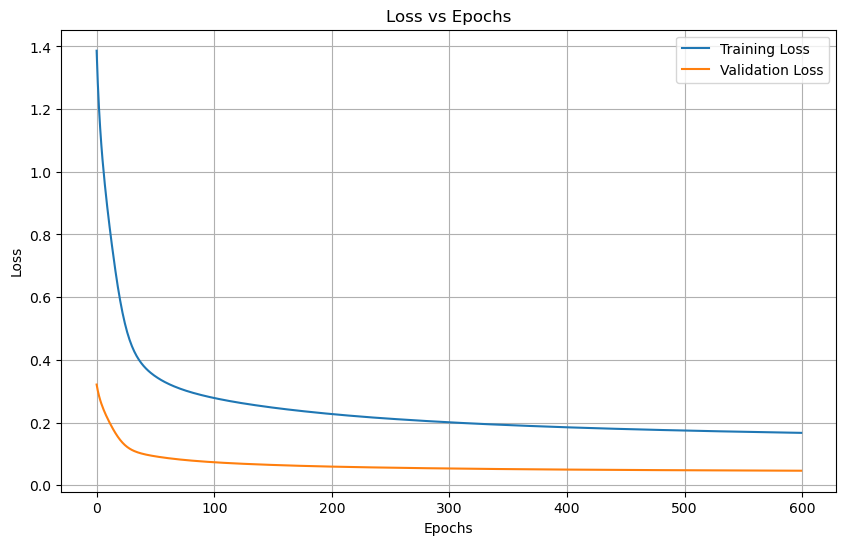

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label="Training Loss")
plt.plot(range(epochs), val_loss, label="Validation Loss")

plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


# Validation

In [25]:
# R² Score Calculation

# Predictions on test data
h1 = X_test_scaled @ w1 + b1
a1 = relu(h1)

h2 = a1 @ w2 + b2
a2 = relu(h2)

y_pred = a2 @ w3 + b3

# Calculate R² score
r2 = r2_score(y_test_scaled, y_pred.detach().numpy())
r2




0.8236828446388245

# save model

In [26]:
# Save the ANN model weights and biases
torch.save({
    'w1': w1,
    'b1': b1,
    'w2': w2,
    'b2': b2,
    'w3': w3,
    'b3': b3,
}, 'ann_model.pth')


<h2>Cross Validation for MSE

In [32]:
# Convert numpy arrays to tensors if not already done
X_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_scaled_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

# K-Fold setup
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cv_r2_scores = []
cv_mae_scores = []
cv_mse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled_tensor)):
    print(f"Fold {fold + 1}/{k}")
    
    # Split into training and validation sets for this fold
    X_train_fold = X_scaled_tensor[train_idx]
    y_train_fold = y_scaled_tensor[train_idx]
    X_val_fold = X_scaled_tensor[val_idx]
    y_val_fold = y_scaled_tensor[val_idx]
    
    # Initialize weights and biases using Xavier initialization
    n_hidden_1 = 64
    n_hidden_2 = 32

    w1 = torch.empty(X_train_fold.shape[1], n_hidden_1)
    lim = xavier_init_uni(X_train_fold.shape[1], n_hidden_1)
    w1.uniform_(-lim, lim)
    b1 = torch.zeros(n_hidden_1)

    w2 = torch.empty(n_hidden_1, n_hidden_2)
    lim = xavier_init_uni(n_hidden_1, n_hidden_2)
    w2.uniform_(-lim, lim)
    b2 = torch.zeros(n_hidden_2)

    w3 = torch.empty(n_hidden_2, 1)
    lim = xavier_init_uni(n_hidden_2, 1)
    w3.uniform_(-lim, lim)
    b3 = torch.zeros(1)

    # Training loop for the current fold
    epochs = 2000
    lr = 0.01
    for epoch in range(epochs):
        # Forward pass
        h1 = X_train_fold @ w1 + b1
        a1 = relu(h1)

        h2 = a1 @ w2 + b2
        a2 = relu(h2)

        y_pred = a2 @ w3 + b3

        # Loss calculation (MSE)
        loss = y_pred - y_train_fold
        n = len(y_train_fold)
        mse = (1 / n) * torch.sum(loss**2)

        # Backward pass and weight updates
        # Output layer
        dw3 = (2 / n) * (a2.T @ loss)
        db3 = (2 / n) * torch.sum(loss)

        # Hidden layer 2
        loss = loss @ w3.T
        loss = loss * (h2 > 0)
        dw2 = (2 / n) * (a1.T @ loss)
        db2 = (2 / n) * torch.sum(loss)

        # Hidden layer 1
        loss = loss @ w2.T
        loss = loss * (h1 > 0)
        dw1 = (2 / n) * (X_train_fold.T @ loss)
        db1 = (2 / n) * torch.sum(loss)

        # Update weights and biases
        w3 -= lr * dw3
        b3 -= lr * db3
        w2 -= lr * dw2
        b2 -= lr * db2
        w1 -= lr * dw1
        b1 -= lr * db1

    # Validation step
    h1 = X_val_fold @ w1 + b1
    a1 = relu(h1)

    h2 = a1 @ w2 + b2
    a2 = relu(h2)

    y_val_pred = a2 @ w3 + b3

    # Inverse scaling (back to the original scale)
    y_val_pred_scaled = y_val_pred.detach().numpy()
    y_val_pred_original = scaler_y.inverse_transform(y_val_pred_scaled)

    # Apply log inverse if the data was log-transformed (e.g., np.exp)
    y_val_pred_original = np.exp(y_val_pred_original)  # Apply log inverse (exp)

    y_val_original = scaler_y.inverse_transform(y_val_fold.detach().numpy())
    y_val_original = np.exp(y_val_original)  # Apply log inverse (exp)

    # R² calculation for the fold
    ss_total = np.sum((y_val_original - np.mean(y_val_original))**2)
    ss_residual = np.sum((y_val_original - y_val_pred_original) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    cv_r2_scores.append(r2)
    
    # MAE and MSE in original scale
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    mse = mean_squared_error(y_val_original, y_val_pred_original)

    cv_mae_scores.append(mae)
    cv_mse_scores.append(mse)
    
    print(f"Fold {fold + 1} R²: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")

# Calculate and print the average scores across all folds
mean_r2_score = np.mean(cv_r2_scores)
mean_mae_score = np.mean(cv_mae_scores)
mean_mse_score = np.mean(cv_mse_scores)

print(f"\nAverage R² Across Folds: {mean_r2_score:.4f}")
print(f"Average MAE Across Folds: {mean_mae_score:.4f}")
print(f"Average MSE Across Folds: {mean_mse_score:.4f}")


/tmp/ipykernel_1814/1931015947.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
/tmp/ipykernel_1814/1931015947.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_scaled_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)


Fold 1/5
Fold 1 R²: 0.8424, MAE: 3564602.0000, MSE: 60618820288512.0000
Fold 2/5
Fold 2 R²: 0.7840, MAE: 4103562.5000, MSE: 71724829769728.0000
Fold 3/5
Fold 3 R²: 0.7858, MAE: 3388872.2500, MSE: 48726064234496.0000
Fold 4/5
Fold 4 R²: 0.8042, MAE: 3156285.2500, MSE: 32338836717568.0000
Fold 5/5
Fold 5 R²: 0.7695, MAE: 4165655.5000, MSE: 89202083495936.0000

Average R² Across Folds: 0.7972
Average MAE Across Folds: 3675795.5000
Average MSE Across Folds: 60522128998400.0000
